# R: Basics of Double Machine Learning

**Remark**: This notebook has a long computation time due to the large number of simulations.

This notebooks contains the detailed simulations according to the introduction to double machine learning in the [User Guide](https://docs.doubleml.org/stable/guide/basics.html) of the DoubleML package.

In [27]:
library(data.table)
library(ggplot2)
library(mlr3)
library(mlr3learners)
library(data.table)
library(DoubleML)

lgr::get_logger("mlr3")$set_threshold("warn")
options(repr.plot.width=5, repr.plot.height=4)

In [28]:
set.seed(1234)
n_rep = 1000
n_obs = 500
n_vars = 5
alpha = 0.5

data = list()
for (i_rep in seq_len(n_rep)) {
    data[[i_rep]] = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars,
                                        return_type="data.frame")
}

In [29]:
non_orth_score = function(y, d, l_hat, m_hat, g_hat, smpls) {
u_hat = y - g_hat
psi_a = -1*d*d
psi_b = d*u_hat
psis = list(psi_a = psi_a, psi_b = psi_b)
return(psis)
}

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"


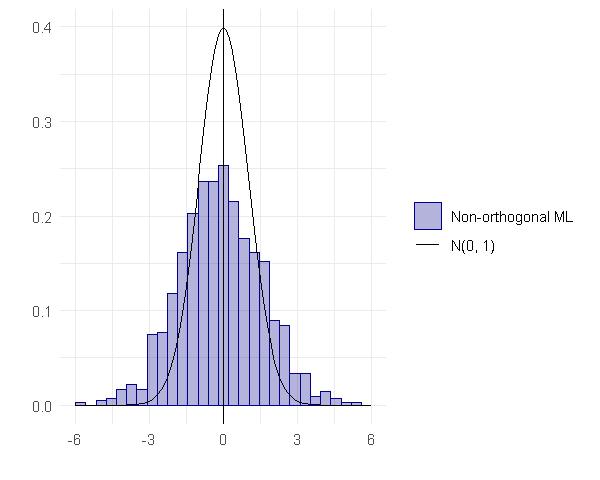

In [30]:
set.seed(1111)

ml_l = lrn("regr.xgboost", nrounds = 50, eta = 0.1)
ml_m = lrn("regr.xgboost", nrounds = 50, eta = 0.1)
ml_g = ml_l$clone()

theta_nonorth = rep(NA, n_rep)
se_nonorth = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)) {
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr_nonorth = DoubleMLPLR$new(obj_dml_data,
                                        ml_l, ml_m, ml_g,
                                        n_folds=2,
                                        score=non_orth_score,
                                        apply_cross_fitting=FALSE)
    obj_dml_plr_nonorth$fit()
    theta_nonorth[i_rep] = obj_dml_plr_nonorth$coef
    se_nonorth[i_rep] = obj_dml_plr_nonorth$se
}

g_nonorth = ggplot(data.frame(theta_rescaled=(theta_nonorth - alpha)/se_nonorth)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Non-orthogonal ML", fill="Non-orthogonal ML"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Non-orthogonal ML", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue", "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Non-orthogonal ML", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

g_nonorth


Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."


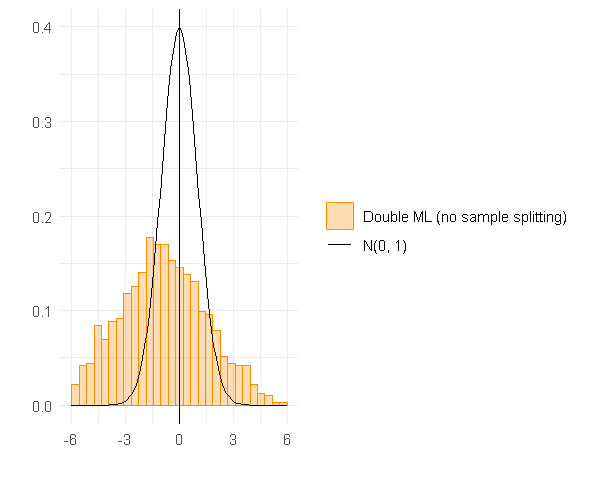

In [31]:
set.seed(2222)

theta_orth_nosplit = rep(NA, n_rep)
se_orth_nosplit = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)){
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr_orth_nosplit = DoubleMLPLR$new(obj_dml_data,
                                        ml_l, ml_m, ml_g,
                                        n_folds=1,
                                        score='IV-type',
                                        apply_cross_fitting=FALSE)
    obj_dml_plr_orth_nosplit$fit()
    theta_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit$coef
    se_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit$se
}

g_nosplit = ggplot(data.frame(theta_rescaled=(theta_orth_nosplit - alpha)/se_orth_nosplit), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

g_nosplit

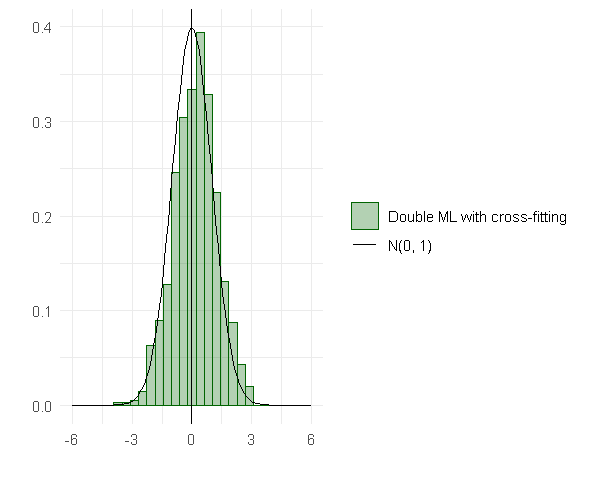

In [32]:
set.seed(3333)

theta_dml = rep(NA, n_rep)
se_dml = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)) {
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr = DoubleMLPLR$new(obj_dml_data,
                                ml_l, ml_m, ml_g,
                                n_folds=2,
                                score='IV-type')
    obj_dml_plr$fit()
    theta_dml[i_rep] = obj_dml_plr$coef
    se_dml[i_rep] = obj_dml_plr$se
}

g_dml = ggplot(data.frame(theta_rescaled=(theta_dml - alpha)/se_dml), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

g_dml

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"


Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."


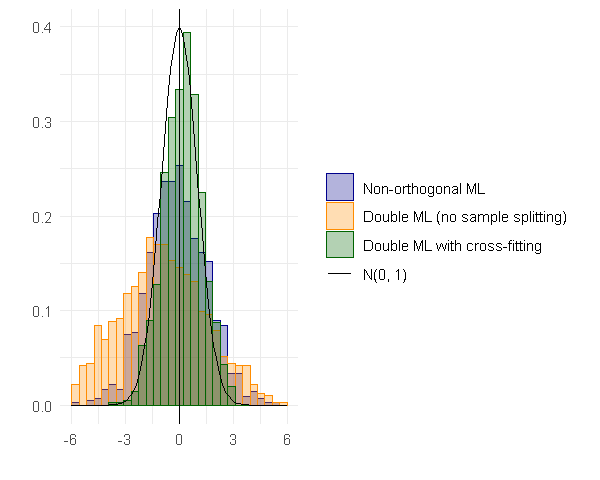

In [33]:
g_all = ggplot(data.frame(t_nonorth=(theta_nonorth - alpha)/se_nonorth,
                        t_orth_nosplit=(theta_orth_nosplit - alpha)/se_orth_nosplit,
                        t_dml=(theta_dml - alpha)/se_dml)) +
                geom_histogram(aes(x = t_nonorth, y=after_stat(density), colour = "Non-orthogonal ML", fill="Non-orthogonal ML"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_orth_nosplit, y=after_stat(density), colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_dml, y=after_stat(density), colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                                bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"=NA)) +
            xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

g_all

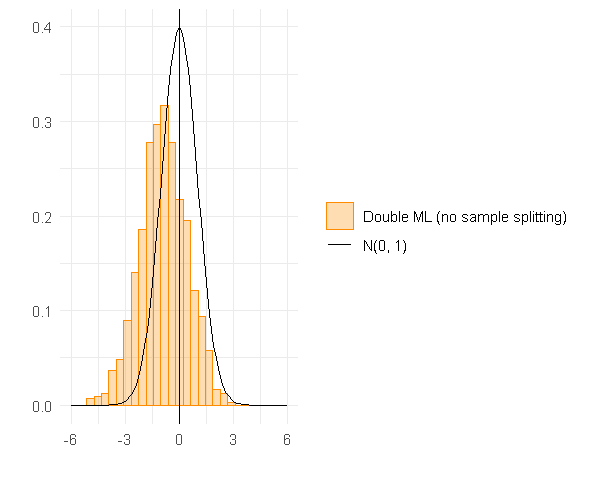

In [34]:
set.seed(4444)

theta_orth_po_nosplit = rep(NA, n_rep)
se_orth_po_nosplit = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)){
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr_orth_nosplit = DoubleMLPLR$new(obj_dml_data,
                                            ml_l, ml_m,
                                            n_folds=1,
                                            score='partialling out',
                                            apply_cross_fitting=FALSE)
    obj_dml_plr_orth_nosplit$fit()
    theta_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit$coef
    se_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit$se
}

g_nosplit_po = ggplot(data.frame(theta_rescaled=(theta_orth_po_nosplit - alpha)/se_orth_po_nosplit), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"='black')) +
                scale_fill_manual(name='',,
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()
g_nosplit_po

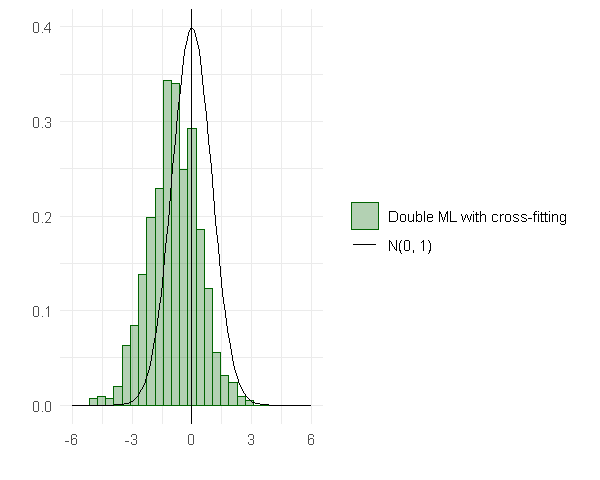

In [35]:
set.seed(5555)

theta_dml_po = rep(NA, n_rep)
se_dml_po = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)) {
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr = DoubleMLPLR$new(obj_dml_data,
                                ml_l, ml_m,
                                n_folds=2,
                                score='partialling out')
    obj_dml_plr$fit()
    theta_dml_po[i_rep] = obj_dml_plr$coef
    se_dml_po[i_rep] = obj_dml_plr$se
}

g_dml_po = ggplot(data.frame(theta_rescaled=(theta_dml_po - alpha)/se_dml_po), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"='black')) +
                scale_fill_manual(name='',,
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()
g_dml_po

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"


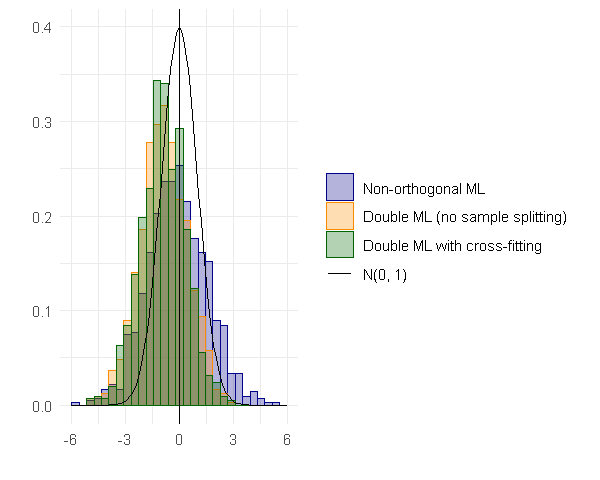

In [36]:
g_all_po = ggplot(data.frame(t_nonorth=(theta_nonorth - alpha)/se_nonorth,
                        t_orth_nosplit=(theta_orth_po_nosplit - alpha)/se_orth_po_nosplit,
                        t_dml=(theta_dml_po - alpha)/se_dml_po)) +
                geom_histogram(aes(x = t_nonorth, y=after_stat(density), colour = "Non-orthogonal ML", fill="Non-orthogonal ML"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_orth_nosplit, y=after_stat(density), colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_dml, y=after_stat(density), colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                                bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"=NA)) +
            xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()
g_all_po

In [37]:
# save all plots
ggsave(filename = "../guide/figures/r_non_orthogonal.svg", plot = g_nonorth, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_dml_nosplit.svg", plot = g_nosplit, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_dml.svg", plot = g_dml, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_all.svg", plot = g_all, dpi = 300, units = "in", width = 6, height = 4)

ggsave(filename = "../guide/figures/r_dml_po_nosplit.svg", plot = g_nosplit_po, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_dml_po.svg", plot = g_dml_po, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_po_all.svg", plot = g_all_po, dpi = 300, units = "in", width = 6, height = 4)

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"
Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"
Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"
